In [1]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [4]:
class Dataset():
    def __init__(self):
        self.labels, self.images = self.load_data()

    def load_data(self):
        labels = {}
        images = {}
        count = 0
        resize = transforms.Compose([transforms.Resize((256, 256))])
        main_dir = os.listdir(os.path.join("dataset", "train"))
        reference = {}

        for i, dir in enumerate(main_dir):
            reference[dir] = i
            images_list = os.listdir(os.path.join("dataset", "train", dir))

            for img in images_list:
                labels[count] = i
                img_path = os.path.join("dataset", "train", dir, img)
                image = Image.open(img_path)
                image = ToTensor()(image)
                images[count] = resize(image)
                count += 1

        print(reference)
        return labels, images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]




In [5]:
class ValDataset(Dataset):
    def load_data(self):
        labels = {}
        images = {}
        count = 0
        resize = transforms.Compose([transforms.Resize((256, 256))])
        main_dir = os.listdir(os.path.join("dataset", "valid"))

        for i, dir in enumerate(main_dir):
            print(i, dir)
            images_list = os.listdir(os.path.join("dataset", "valid", dir))

            for img in images_list:
                labels[count] = i
                img_path = os.path.join("dataset", "valid", dir, img)
                image = Image.open(img_path)
                image = ToTensor()(image)
                images[count] = resize(image)
                count += 1

        return labels, images

valdataset = ValDataset()


0 AKIEC


c:\Users\raush\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1 BCC
2 BKL
3 DF
4 MEL
5 NV
6 VASC


In [6]:
# Model Architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images 
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)
        
        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)
        
        
    def forward(self,t):
        t = t
        
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)
        
        
        t=self.fc2(t)
        t=F.relu(t)
        
        t=self.out(t)
        
        
        return t

In [7]:
model = Network()

In [8]:
dataset = Dataset()

{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


In [9]:
valdataset = ValDataset()

0 AKIEC
1 BCC
2 BKL
3 DF
4 MEL
5 NV
6 VASC


In [10]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train(dataset, valdataset, model, num_epochs=20, batch_size=64, val_batch_size=32, lr=0.001):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    valdataloader = DataLoader(valdataset, batch_size=val_batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = []
    losses = []

    for epoch in range(num_epochs):
        tot_loss = 0
        tot_correct = 0

        for x, y in dataloader:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for x_val, y_val in valdataloader:
                y_val_pred = model(x_val)
                val_loss = criterion(y_val_pred, y_val)
                tot_loss += val_loss.item()
                tot_correct += get_num_correct(y_val_pred, y_val)

        epochs.append(epoch)
        losses.append(tot_loss)
        print(f"Epoch {epoch}, total_correct {tot_correct}, loss: {tot_loss}")
        torch.save(model.state_dict(), f"model_ep{epoch + 1}.pth")

    # Plot a Validation Loss vs Epochs graph
    plt.plot(epochs, losses, color='green', linewidth=3, marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('epochs ---->', color='m', fontsize='xx-large')
    plt.ylabel('loss ------>', color='m', fontsize='xx-large')
    axes = plt.gca()
    axes.set_facecolor('c')
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch", color='m', fontsize='xx-large')

# Assuming get_num_correct is a function that calculates the number of correct predictions
def get_num_correct(pred, target):
    return torch.sum(torch.argmax(pred, dim=1) == target).item()


In [16]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 20
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph 
    plt.plot(epochs, losses, color='green', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' ) 
    plt.ylabel('loss ------>',color='m',fontsize='xx-large') 
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 80 loss: 25.226280212402344
Epoch 1 total_correct 55 loss: 27.65824520587921
Epoch 2 total_correct 92 loss: 26.551257610321045
Epoch 3 total_correct 75 loss: 25.452657103538513
Epoch 4 total_correct 80 loss: 25.042081236839294
Epoch 5 total_correct 81 loss: 26.257376670837402
Epoch 6 total_correct 104 loss: 24.38540244102478
Epoch 7 total_correct 119 loss: 22.242136120796204
Epoch 8 total_correct 108 loss: 23.659852623939514
Epoch 9 total_correct 109 loss: 21.99254274368286
Epoch 10 total_correct 118 loss: 21.57244634628296
Epoch 11 total_correct 118 loss: 22.317439317703247
Epoch 12 total_correct 122 loss: 23.085451245307922
Epoch 13 total_correct 124 loss: 22.247928380966187
Epoch 14 total_correct 127 loss: 25.876235246658325
Epoch 15 total_correct 134 loss: 24.099319219589233
Epoch 16 total_correct 121 loss: 29.28242552280426
Epoch 17 total_correct 117 loss: 28.698511481285095
Epoch 18 total_correct 137 loss: 31.24183750152588
Epoch 19 total_correct 149 loss: 3

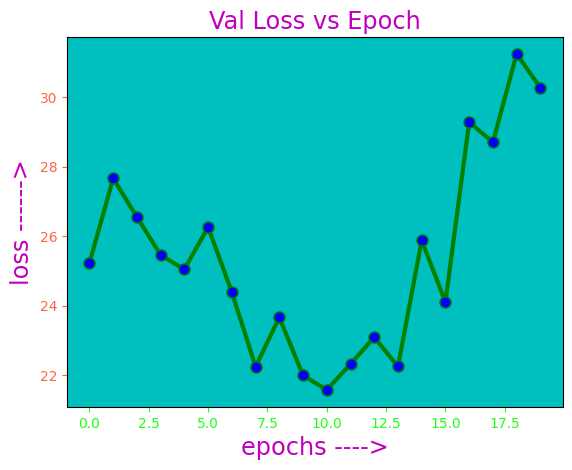

In [17]:
train(dataset,valdataset, model)

In [18]:
# Saving labels to label value as a json
main_dir = os.listdir(os.path.join("dataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [19]:
#Save the trained model
torch.save(model.state_dict(), "model.pth")

In [20]:
# prediction function to test
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break
      



In [21]:
predict(r"C:\Users\raush\Desktop\temp\Kaggle GC\dataset\train\BCC\ISIC_0025584.jpg")

BKL


In [22]:
import os
from PIL import Image
from torchvision.transforms import ToTensor, transforms

# Assuming 'model' and 'reference' are defined somewhere in your code

def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256, 256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key, value in reference.items():
        if value == result_idx:
            print(key)
            break

# Specify the directory containing the test images
test_dir = os.path.join("dataset", "test")

# Iterate over image files in the test directory
for filename in os.listdir(test_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions as needed
        img_path = os.path.join(test_dir, filename)
        a ,b =os.path.split(img_path)
        print(f"Predicting for: {b}")
        predict(img_path)


Predicting for: dataset\test\ISIC_0034524.jpg
NV
Predicting for: dataset\test\ISIC_0034525.jpg
NV
Predicting for: dataset\test\ISIC_0034526.jpg
BCC
Predicting for: dataset\test\ISIC_0034527.jpg
NV
Predicting for: dataset\test\ISIC_0034528.jpg
NV
Predicting for: dataset\test\ISIC_0034529.jpg
NV
Predicting for: dataset\test\ISIC_0034530.jpg
NV
Predicting for: dataset\test\ISIC_0034531.jpg
BKL
Predicting for: dataset\test\ISIC_0034532.jpg
NV
Predicting for: dataset\test\ISIC_0034533.jpg
NV
Predicting for: dataset\test\ISIC_0034534.jpg
NV
Predicting for: dataset\test\ISIC_0034535.jpg
AKIEC
Predicting for: dataset\test\ISIC_0034536.jpg
AKIEC
Predicting for: dataset\test\ISIC_0034537.jpg
NV
Predicting for: dataset\test\ISIC_0034538.jpg
BKL
Predicting for: dataset\test\ISIC_0034539.jpg
NV
Predicting for: dataset\test\ISIC_0034540.jpg
NV
Predicting for: dataset\test\ISIC_0034541.jpg
NV
Predicting for: dataset\test\ISIC_0034542.jpg
NV
Predicting for: dataset\test\ISIC_0034543.jpg
NV
Predicting 

In [29]:
import os
import csv
from PIL import Image
from torchvision.transforms import ToTensor, transforms

# Assuming 'model' and 'reference' are defined somewhere in your code

def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256, 256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    
    # Find the class label based on the reference dictionary
    predicted_class = None
    for key, value in reference.items():
        if value == result_idx:
            predicted_class = key
            break
            
    return predicted_class

# Specify the directory containing the test images
test_dir = os.path.join("dataset", "test")
class_label_mapping = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}

# Specify the CSV file path
csv_file_path = r"C:\Users\raush\Desktop\temp\delete2\predictions.csv"

# Iterate over image files in the test directory and write predictions to CSV
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['Image Filename', 'Prediction']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header row
    writer.writeheader()

    for filename in os.listdir(test_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions as needed
            img_path = os.path.join(test_dir, filename)
            predicted_class = predict(img_path)
            
            # Write the image filename and prediction to the CSV file
            writer.writerow({'Image Filename': filename[:12], 'Prediction': class_label_mapping[predicted_class]})

print(f'CSV file "{csv_file_path}" created successfully.')


c:\Users\raush\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


CSV file "C:\Users\raush\Desktop\temp\delete2\predictions.csv" created successfully.


In [25]:
predict(r"C:\Users\raush\Desktop\temp\Kaggle GC\dataset\train\DF\ISIC_0029297.jpg")

VASC


In [28]:
class_label_mapping = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
print(class_label_mapping['MEL'])

0
